In [ ]:
# when the probability topic gains popularity, what has changed for the topic itself?

In [1]:
import logging
from gensim.models import ldaseqmodel
from gensim.corpora import Dictionary, bleicorpus, textcorpus
import numpy as np
from gensim.matutils import hellinger
import time
import pickle
import pyLDAvis
import matplotlib.pyplot as plt
import os
from scipy.stats import entropy
from scipy import stats

from IPython.core.debugger import set_trace

In [18]:
# load data
alldata_new = pickle.load(open('output/dtm_processed_output.p', 'rb'))
doc_year=alldata_new['docs_per_year']
doc_ids =[0]+list(np.cumsum(doc_year))

term_topic = alldata_new['term_topic']# term_topic is n_years*n_topics*n_terms
terms = alldata_new['terms']

doc_topicyrs = alldata_new['doc_topic']

doc_topic = []
for year in range(len(term_topic)):    
    doc_topic.append(alldata_new['doc_topic'][doc_ids[year]:doc_ids[year+1]])# doc_topic is nyear*n_docs given year*n_topics
    
# rename topics by the hand-picked names
topic_labels = pickle.load(open('topicnames.p','rb'))


term_frequency = alldata_new['term_frequency'][1:] # weirdly the first entry is empty

In [4]:
[print(str(i)+': '+topic_labels[i]) for i in range(len(topic_labels))]

0: Sequential learning
1: Face and emotion perception
2: Reasoning
3: Text processing and creativity
4: Mathematical cognition
5: Decision making
6: Language: syntax
7: Causal reasoning
8: Knowledge structure
9: Developmental psychology
10: Spatial cognition and embodied cognition
11: Memory
12: Categorization
13: Language: semantics
14: Educational psychology
15: Network models for cognition and Neuroscience
16: non-verbal communication
17: Probabilistic modeling
18: Consciousness and identity
19: Visual attention


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

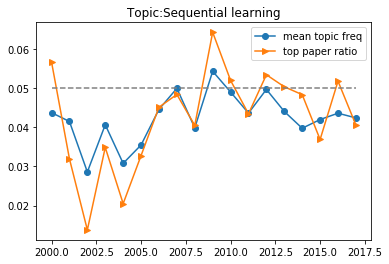

/Users/zhiwei/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/zhiwei/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


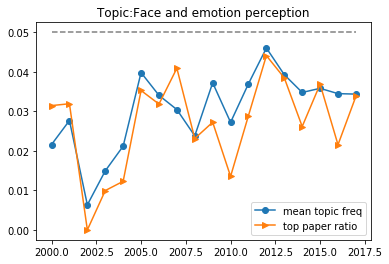

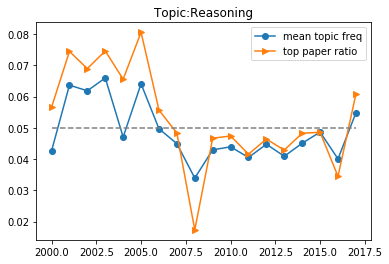

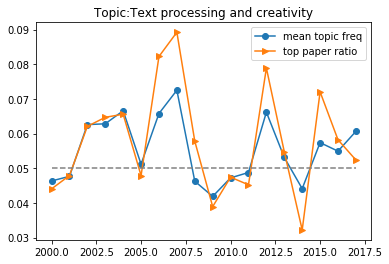

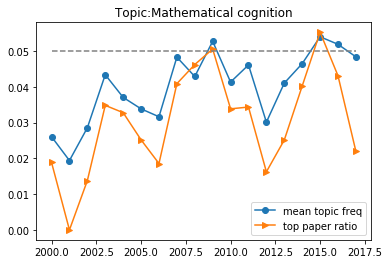

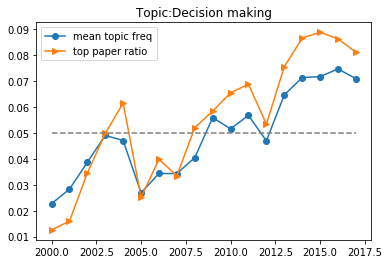

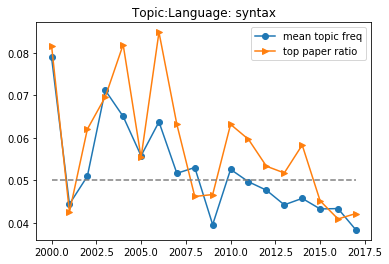

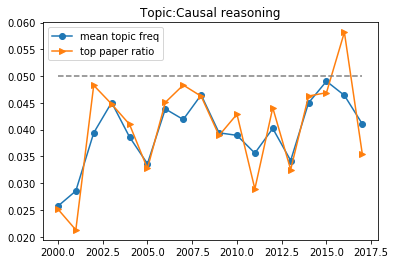

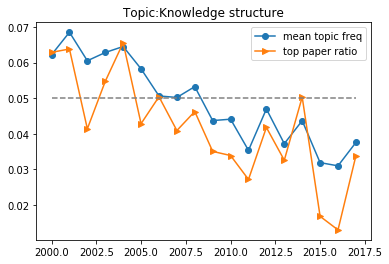

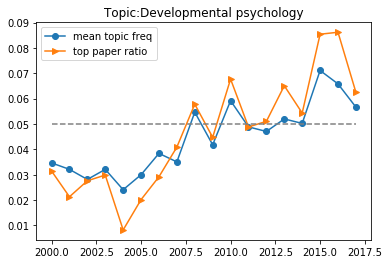

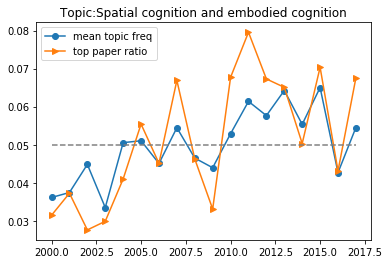

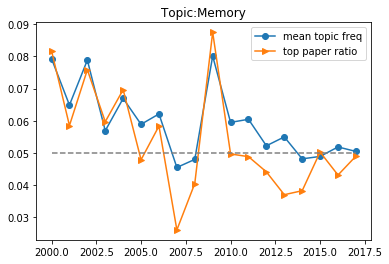

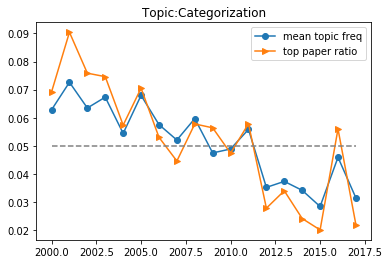

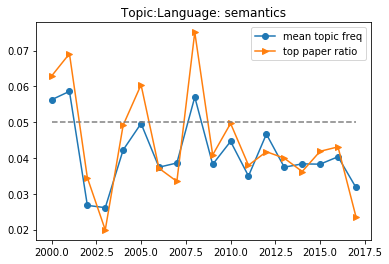

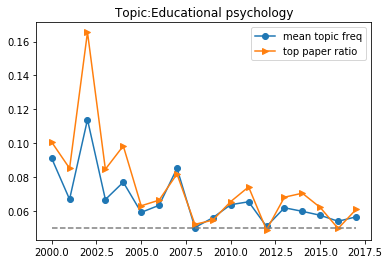

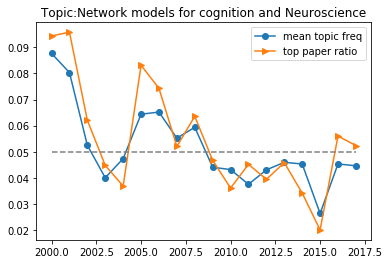

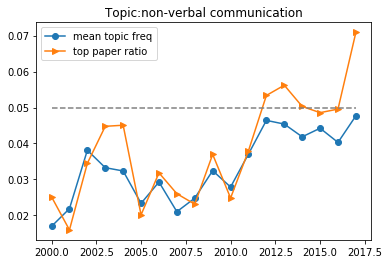

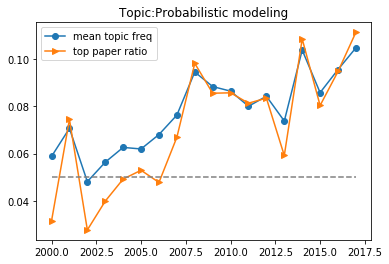

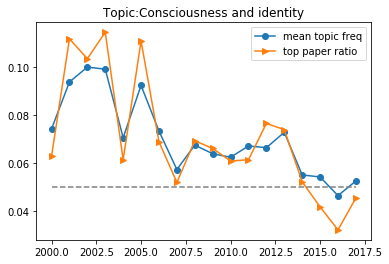

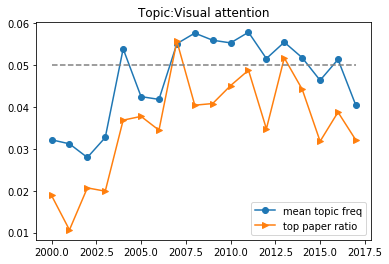

In [12]:
# 2 ways of characterize the trend: 1) proportion of papers counted as mainly probabilistic 2) mean freq of prob topics in each year
#ntop=7 # index for probability topic
alltopfreq=[]
allppratio=[]
allppen=[]
for ntop in range(20):
    paperratio=np.empty(len(term_topic))
    topfreq=np.empty(len(term_topic))
    ppen_years=np.empty(len(term_topic))
    for year in range(len(term_topic)):
        topfreq[year]=np.mean(doc_topic[year],axis=0)[ntop]
        paperratio[year]=sum(np.argmax(doc_topic[year],axis=1)==ntop)/len(doc_topic[year])
        ppentropy = []
        idx = np.where(np.argmax(doc_topic[year],axis=1)==ntop) 
        topicds=doc_topic[year][idx]
        for d in topicds:
            ppentropy.append(entropy(d))
            if np.isnan(entropy(d)):
                set_trace()
        ppen_years[year]=np.mean(ppentropy) #averaged across all top papers in this year
    alltopfreq.append(topfreq)
    allppratio.append(paperratio)
    allppen.append(ppen_years)
    
    plt.plot(np.arange(len(term_topic))+2000,topfreq,'-o',label='mean topic freq')
    plt.plot(np.arange(len(term_topic))+2000,paperratio,'->',label='top paper ratio')
    plt.plot(np.arange(len(term_topic))+2000,np.ones_like(topfreq)*(1/20),'--',color=[.5,.5,.5])
    ax=plt.gca()
    ax.legend()
    #ax2=ax.twinx()
    #ax2.plot(np.arange(len(term_topic))+2000,ppen_years,'-s',color=[0,.9,0],label='top paper entropy')
    
    plt.title('Topic:'+topic_labels[ntop])
    plt.legend()
    plt.show()
    plt.savefig('figures/rise_of_prob_topic/2freqs/'+topic_labels[ntop])

In [ ]:
# turns out most topics have similar amount for the 2 criteria, yet for probabilistic modeling, learning and memory ("trial"), problem solving("rule"), the paper ratio is significantly lower. 
# that indicates: many paper with other major topics still have a sizeble amount of stress on these topics.

In [33]:
nface=1
nprob=17
ndecision=5
nnetwork=15
nstud=14

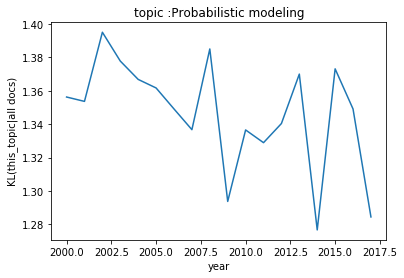

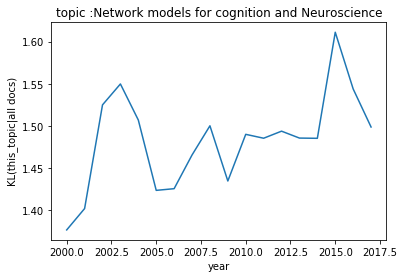

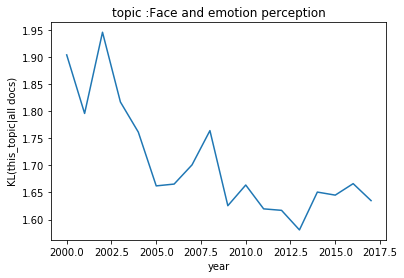

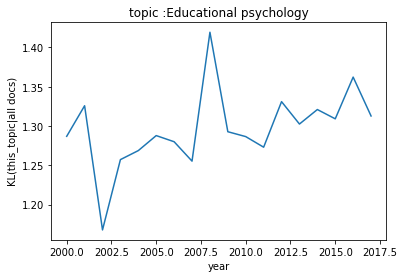

In [34]:
# topic content change during the rise of a topic: KLdiv with other topics are closer? maybe also in the t-sne space?
for ntop in [nprob,nnetwork,nface,nstud]:
    topic_KL = []
    for year in range(len(term_topic)):
        ttop=term_topic[year]
        tfreq=term_frequency[year]/sum(term_frequency[year])
        topic_KL.append(entropy(tfreq,ttop[ntop])) # to avoid infinite (some terms of the topic has 0 probability)
    plt.plot(np.arange(len(term_topic))+2000,topic_KL)
    plt.title('topic :'+topic_labels[ntop])
    plt.ylabel('KL(this topic|all docs)')
    plt.xlabel('year')
    plt.show()

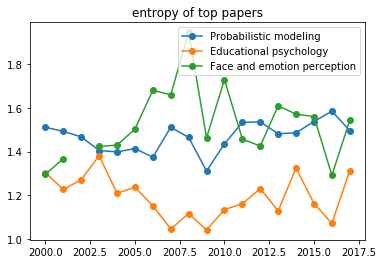

In [13]:
# analyze top papers' entropy and compare topics -- no clear conclusion. probability has been a mixed field always.


for ntop in [nprob,nstud,nface]:
    ppen_years = allppen[ntop]
    plt.plot(np.arange(len(term_topic))+2000,ppen_years,'-o',label=topic_labels[ntop])
    plt.title('entropy of top papers')
plt.legend()
plt.show()

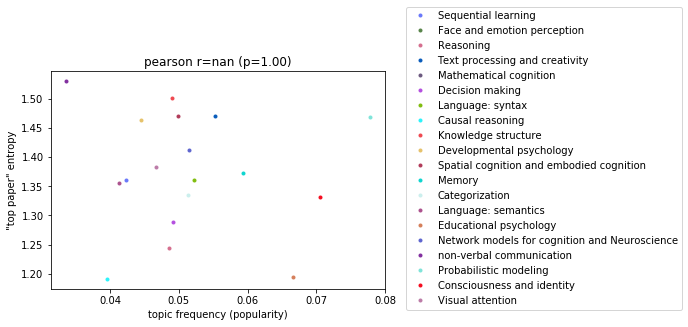

In [8]:
# top paper entropy and topic popularity: any relation? -- yes, sort of positive correlation. Though counter example exists
"""for ntop in range(len(topic_labels)):
    plt.plot(np.mean(allppratio[ntop]),np.mean(allppen[ntop]),'.')
plt.show()"""

avtopfreq= []
avppentro=[]
for ntop in range(len(topic_labels)):
    """    if ntop==nstud:
        continue
"""    
    avtopfreq.append(np.mean(alltopfreq[ntop]))
    avppentro.append(np.mean(allppen[ntop]))
    plt.plot(np.mean(alltopfreq[ntop]),np.mean(allppen[ntop]),'.',color=np.random.rand(3),label=topic_labels[ntop])

                     
r=stats.pearsonr(avtopfreq,avppentro)                     
plt.legend(loc='center right',bbox_to_anchor=(1.9, .6))
plt.title('pearson r=%.2f (p=%.2f)'%r)
plt.xlabel('topic frequency (popularity)')
plt.ylabel('"top paper" entropy')
                     
plt.show()


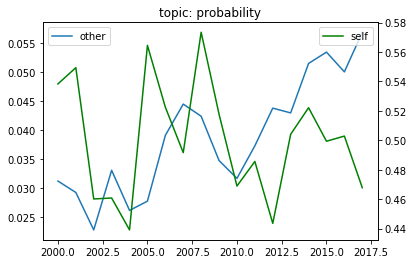

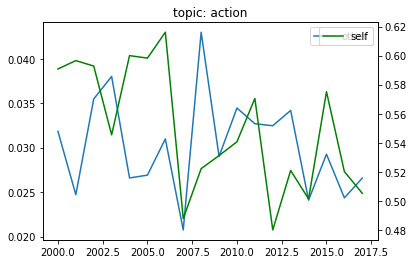

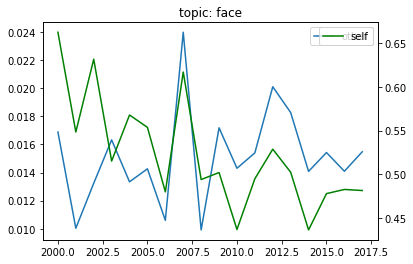

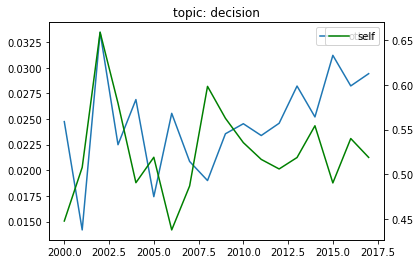

In [57]:
# how this topic has invaded other topics...not a useful analysis. if just frequency, it's like the same question. Plus unclear the self/other distinction is so useful...
for ntop in [nprob,naction,nface,ndecision]:
    freq_other=[]
    freq_self=[]
    for year in range(len(doc_year)):
        topfreq=[]
        topfreq_self=[]
        for thisdoc in doc_topic[year]:
            if np.argmax(thisdoc)!=ntop:
                topfreq.append(thisdoc[ntop])
            else:
                topfreq_self.append(thisdoc[ntop])
        freq_other.append(np.mean(topfreq))
        freq_self.append(np.mean(topfreq_self))
    plt.plot(np.arange(len(term_topic))+2000,freq_other,label='other')
    plt.title('topic: '+topic_labels[ntop])
    ax=plt.gca()
    ax.legend()
    ax2=ax.twinx()
    ax2.plot(np.arange(len(term_topic))+2000,freq_self,color='g',label='self')
    ax2.legend()

    plt.show()
    

In [21]:
topic_KL

[1.2641508610779699,
 1.2687917422222534,
 1.2732177049066271,
 1.2770138613242918,
 1.2804786504145853,
 1.2834375299451735,
 1.2857825667293081,
 1.2874024287421626,
 1.2885586624259893,
 1.2902281149950239,
 1.2926376334072638,
 1.2961358391322411,
 1.3015236488374777,
 1.3085979409971429,
 1.3163290175132718,
 1.3249994060466521,
 1.3344055892315985,
 1.3408901261665891]